In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

In [2]:
def gen_one_hot(N = 10, dim = 10):
    int_array = np.array(random.sample(range(dim), N))
    onehots = np.zeros((int_array.size, dim))
    onehots[np.arange(int_array.size), int_array] = 1
    return onehots

def gen_sphere(N = 10, dim = 10):
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius
    return points.T

def gen_normal(N = 10, dim = 10):
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    return normal_deviates.T

def gen_binary(N = 10, dim = 10):
    return np.random.randint(2, size=(N,dim))*2-1 

def get_delta(pts, get_min = True):
    N, dim = pts.shape
    adj = np.zeros((N,N))
    
    for row in range(N):
        for col in range(N):
            adj[row,col] = np.dot(pts[row], pts[row]) - np.dot(pts[row], pts[col])
                
    max_entry = np.max(adj)
    for row in range(N):
        adj[row, row] = max_entry
    
    if get_min:
        return np.min(adj)
    else:
        return adj

def get_data_max_norm(pts):
    return np.sqrt(np.max(np.sum(pts**2, axis = 1)))

def get_delta_lower_cond(pts, beta = 1, chunk = 1):
    N, dim = pts.shape
    N = int(N / chunk)
    M = get_data_max_norm(pts)
    
    lower_bound = 2/(N*beta) + 1/beta * np.log(2*(N-1)*N*beta*M**2)
    
    return lower_bound

def get_proj_comp(u,v):
    return np.dot(u, v)/np.sqrt(sum(v**2))

def get_proj_adj(pts):
    N, dim = pts.shape
    adj = np.zeros((N,N))
    
    for row in range(N):
        for col in range(N):
            adj[row,col] = get_proj_comp(pts[row], pts[col])
    
    return adj

def get_proj_prob(pts, threshold):
    adj = get_proj_adj(pts)
    M = get_data_max_norm(pts)
    thres = min(M,threshold)

    num_in = np.size(adj[np.abs(adj) <= thres])
    total_pair = np.size(adj) - adj.shape[0]
    
    return num_in / total_pair, num_in

def delta_bar(M, N, beta, delta):
    return 2*M*(N-1)*np.exp(2/N -beta*delta)

def get_prob_box(pts, threshold):
    N, dim = pts.shape
    num_in = 0
    abs_pts = np.abs(pts)
    for r in range(N):
        if np.max(pts[r]) < threshold:
            num_in = num_in + 1
    
    total = N
    return num_in/ total

In [4]:
adv_log = pd.DataFrame()

runs = 10
Ns = [5]
dim = range(1000,150000, 20000)

# runs = 200
# Ns = [5, 10, 15]
# dim = range(1000,150000, 10000)
max_entry = []
beta_base = 10
deltas = []
lower_conds = []
prob_projs = []

report_result = dict()

for r in range(runs):
    for N in Ns:
        for d in dim:
            sentence = gen_sphere(N = N, dim = d)
            beta = beta_base
            delta = get_delta(sentence)
            M = get_data_max_norm(sentence)
            threshold = 1/(N*M*beta)
            prob_proj = get_proj_prob(sentence, threshold)[0]
            lower_cond = get_delta_lower_cond(gen_sphere(N = N, dim = d), beta = beta, chunk = 1)
            delta_b = delta_bar(M, N, beta, delta)
            prob_box = get_prob_box(sentence, delta_b*3)
            adv = max(prob_proj + prob_proj**(2*N) -prob_box - 1, 0)
                              
            report_result = {'dim': d,
                             'data': 'sphere',
                             'delta': delta,
                             'low': lower_cond,
                             'p_proj': prob_proj,
                              'length': N,
                              'prob_box': prob_box,
                              'Adv' :  adv}

            adv_log = pd.concat([adv_log, pd.DataFrame.from_records([report_result])])

beta_base = 10

for r in range(runs):
    for N in Ns:
        for d in dim:
            beta = beta_base/d
            sentence = gen_normal(N = N, dim = d)
            delta = get_delta(sentence)
            M = get_data_max_norm(sentence)
            threshold = 1/(N*M*beta)
            prob_proj = get_proj_prob(sentence, threshold)[0]
            lower_cond = get_delta_lower_cond(gen_normal(N = N, dim = d), beta = beta, chunk = 1)
            delta_b = delta_bar(M, N, beta, delta)
            prob_box = get_prob_box(sentence, delta_b*3)
            adv = max(prob_proj + prob_proj**(2*N) -prob_box - 1, 0)
                              
            report_result = {'dim': d,
                             'data': 'gauss',
                             'delta': delta,
                             'low': lower_cond,
                             'p_proj': prob_proj,
                              'length': N,
                              'prob_box': prob_box,
                              'Adv' :  adv}
            
#             print(adv)

            adv_log = pd.concat([adv_log, pd.DataFrame.from_records([report_result])])
    
runs = 10
beta_base = 10


for r in range(runs):
    for N in Ns:
        for d in dim:
            beta = beta_base
            sentence = gen_one_hot(N = N, dim = d)
            delta = get_delta(sentence)
            M = get_data_max_norm(sentence)
            threshold = 1/(N*M*beta)
            prob_proj = get_proj_prob(sentence, threshold)[0]
            lower_cond = get_delta_lower_cond(gen_one_hot(N = N, dim = d), beta = beta, chunk = 1)
            delta_b = delta_bar(M, N, beta, delta)
            prob_box = get_prob_box(sentence, delta_b*3)
            adv = max(prob_proj + prob_proj**(2*N) -prob_box - 1, 0)
                              
            report_result = {'dim': d,
                             'delta': delta,
                             'data': 'one-hot',
                             'low': lower_cond,
                             'p_proj': prob_proj,
                              'length': N,
                              'prob_box': prob_box,
                              'Adv' :  adv}

            adv_log = pd.concat([adv_log, pd.DataFrame.from_records([report_result])])

In [4]:
adv_log['Condition Ratio'] = adv_log['delta']/ adv_log['low']
adv_log['Setting'] = adv_log['data'] + '-'+ adv_log["length"].astype(str) 

In [5]:
# save_log = "adv_data_done.pkl"
# adv_log = pd.read_pickle(save_log)

{'sphere-5': (4, 1.5), 'sphere-10': (1, 1), 'sphere-15': (3, 1.25, 1.5, 1.25), 'gauss-5': (4, 1.5), 'gauss-10': (1, 1), 'gauss-15': (3, 1.25, 1.5, 1.25), 'one-hot-5': (4, 1.5), 'one-hot-10': (1, 1), 'one-hot-15': (3, 1.25, 1.5, 1.25)}


/scratch/local/63940636/ipykernel_119652/880145026.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/63940636/ipykernel_119652/880145026.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


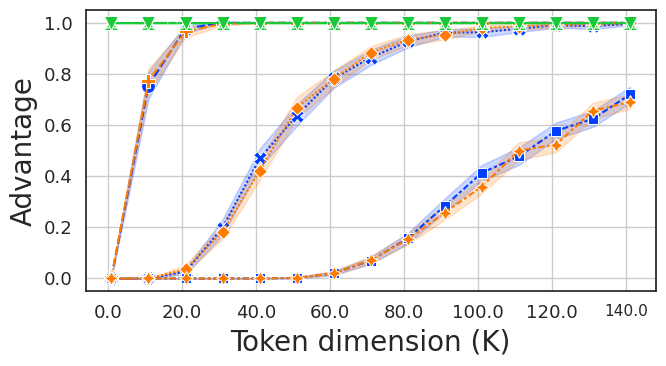

In [6]:
import seaborn as sns
from matplotlib.ticker import NullFormatter


sns.set_style("ticks")
sns.set_context("paper")
sns.set(font_scale=1)

def formatter(x, pos):
    return str(round(x / 1e3, 0))

def formatter_y(x, pos):
    return str(round(x, 1))

subscale_dict = {'sphere-5': 'sphere',
                'sphere-10': 'sphere',
                'sphere-15': 'sphere',
                'gauss-5': 'gauss',
                'gauss-10': 'gauss',
                'gauss-15': 'gauss',
                'one-hot-5': 'one-hot',
                'one-hot-10': 'one-hot',
                'one-hot-15': 'one-hot',}

dash_list = sns._core.unique_dashes(adv_log['Setting'].unique().size+1)

style = {key:value for key,value in zip(adv_log['Setting'].unique(), dash_list[1:])}
style_key = list(style.keys())
style[style_key[3]] = style[style_key[0]]
style[style_key[4]] = style[style_key[1]]
style[style_key[5]] = style[style_key[2]]
style[style_key[6]] = style[style_key[0]]
style[style_key[7]] = style[style_key[1]]
style[style_key[8]] = style[style_key[2]]

plt.figure(figsize = (7,4))
sns.set(style='white',)
g = sns.lineplot( x="dim", y="Adv", 
                     data=adv_log, 
                     hue='data',
                     style='Setting', dashes=style,
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, markersize=10,
                     legend=True)

sns.set(font_scale = 1.5)
g.set(title ='')
g.set_xlabel(xlabel ="Token dimension (K)", size = 20)
g.set_ylabel(ylabel ="Advantage", size = 20)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

# plt.xlabel(fontsize=16)

plt.grid()
# plt.legend(bbox_to_anchor = (1.03, 1.02), fontsize = 10)
handles, labels = g.get_legend_handles_labels()
index_item_title = labels.index('Setting')

color_dict = {label: handle.get_color()
              for handle, label in zip(handles[1:index_item_title], labels[1:index_item_title])}


# loop through the items, assign color via the subscale of the item idem
for handle, label in zip(handles[index_item_title + 1:], labels[index_item_title + 1:]):
    handle.set_color(color_dict[subscale_dict[ label]])

# create a legend only using the items
lgnd = g.legend(handles[index_item_title + 1:], labels[index_item_title + 1:], title='',
          bbox_to_anchor=(1.03, 0.8), fontsize=10, facecolor="gray", framealpha=0.1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i].set_markersize(10)
    lgnd.legendHandles[i].set_markeredgecolor('white')

lgnd.remove()

plt.tight_layout()

# plt.savefig('adv_theory.pdf')

/scratch/local/63940636/ipykernel_119652/1786853593.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/63940636/ipykernel_119652/1786853593.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


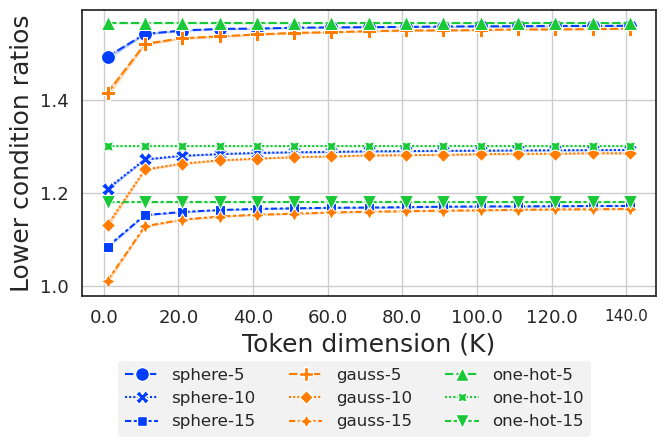

In [7]:
import seaborn as sns
from matplotlib.ticker import NullFormatter


sns.set_style("ticks")
sns.set_context("paper")
sns.set(font_scale=1)

def formatter(x, pos):
    return str(round(x / 1e3, 0))

def formatter_y(x, pos):
    return str(round(x, 1))

subscale_dict = {'sphere-5': 'sphere',
                'sphere-10': 'sphere',
                'sphere-15': 'sphere',
                'gauss-5': 'gauss',
                'gauss-10': 'gauss',
                'gauss-15': 'gauss',
                'one-hot-5': 'one-hot',
                'one-hot-10': 'one-hot',
                'one-hot-15': 'one-hot',}

dash_list = sns._core.unique_dashes(adv_log['Setting'].unique().size+1)

style = {key:value for key,value in zip(adv_log['Setting'].unique(), dash_list[1:])}
style_key = list(style.keys())
style[style_key[3]] = style[style_key[0]]
style[style_key[4]] = style[style_key[1]]
style[style_key[5]] = style[style_key[2]]
style[style_key[6]] = style[style_key[0]]
style[style_key[7]] = style[style_key[1]]
style[style_key[8]] = style[style_key[2]]

plt.figure(figsize = (7,5))
sns.set(style='white',)
g = sns.lineplot( x="dim", y="Condition Ratio", 
                     data=adv_log, 
                     hue='data',
                     style='Setting', dashes=style,
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, markersize=10,
                     legend=True)

sns.set(font_scale = 1.5)
g.set(title ='')
g.set_xlabel(xlabel ="Token dimension (K)", size = 18)
g.set_ylabel(ylabel ="Lower condition ratios", size = 18)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

# plt.xlabel(fontsize=16)

plt.grid()
# plt.legend(bbox_to_anchor = (1.03, 1.02), fontsize = 10)
handles, labels = g.get_legend_handles_labels()
index_item_title = labels.index('Setting')

color_dict = {label: handle.get_color()
              for handle, label in zip(handles[1:index_item_title], labels[1:index_item_title])}


# loop through the items, assign color via the subscale of the item idem
for handle, label in zip(handles[index_item_title + 1:], labels[index_item_title + 1:]):
    handle.set_color(color_dict[subscale_dict[ label]])

# create a legend only using the items
lgnd = g.legend(handles[index_item_title + 1:], labels[index_item_title + 1:], title='',
          bbox_to_anchor=(0.9, -0.2), fontsize=12, facecolor="gray", framealpha=0.1, ncol = 3)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i].set_markersize(10)
    lgnd.legendHandles[i].set_markeredgecolor('white')

# lgnd.remove()

plt.tight_layout()

plt.savefig('cond_theory.pdf')

/scratch/local/63940636/ipykernel_119652/1824044299.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/63940636/ipykernel_119652/1824044299.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


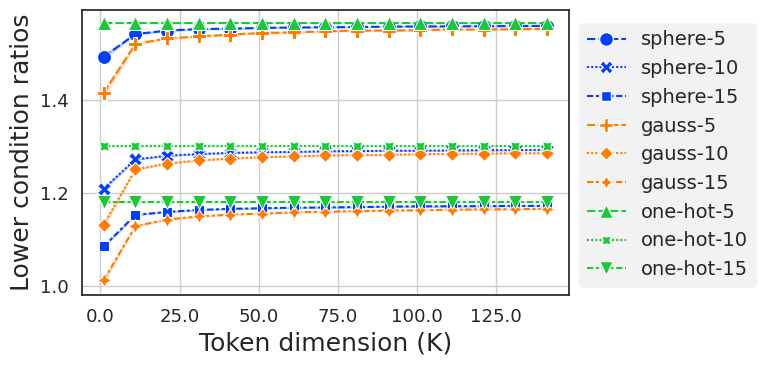

In [8]:
plt.figure(figsize = (8,4))
sns.set(style='white',)
g = sns.lineplot( x="dim", y="Condition Ratio", 
                     data=adv_log, 
                     hue='data',
                     style='Setting', dashes=style,
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, markersize=10,
                     legend=True)

sns.set(font_scale = 1.5)
g.set(title ='')
g.set_xlabel(xlabel ="Token dimension (K)", size = 18)
g.set_ylabel(ylabel ="Lower condition ratios", size = 18)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

# plt.xlabel(fontsize=16)

plt.grid()
# plt.legend(bbox_to_anchor = (1.03, 1.02), fontsize = 10)
handles, labels = g.get_legend_handles_labels()
index_item_title = labels.index('Setting')

color_dict = {label: handle.get_color()
              for handle, label in zip(handles[1:index_item_title], labels[1:index_item_title])}


# loop through the items, assign color via the subscale of the item idem
for handle, label in zip(handles[index_item_title + 1:], labels[index_item_title + 1:]):
    handle.set_color(color_dict[subscale_dict[ label]])

# create a legend only using the items
lgnd = g.legend(handles[index_item_title + 1:], labels[index_item_title + 1:], title='',
          bbox_to_anchor=(1.0, 0.99), fontsize=14, facecolor="gray", framealpha=0.1)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i].set_markersize(10)
    lgnd.legendHandles[i].set_markeredgecolor('white')

# lgnd.remove()

plt.tight_layout()
# plt.savefig('cond_theory_horizontal.pdf')